# Fitting neutralization curves to replicates for FI6v3
In this notebook, we fit individual neutralization curves to all the replicates for FI6v3.
We then compare the IC50s to see for variants are significantly different than wildtype.

## Import modules / functions
Imports needed to run the rest of the notebook:

In [1]:
import pandas
import numpy
from scipy.stats import ttest_ind
from IPython.display import HTML, display
from statsmodels.sandbox.stats.multicomp import multipletests

import dms_tools2
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
import dms_tools2.neutcurve
from dms_tools2.ipython_utils import showPDF

Using dms_tools2 version 2.2.1


/Users/jbloom/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Plot neutralization curves
We have three replicates for each variants. 
First simply fit and plot the neutralization curves.
We do this using [dms_tools2.neutcurve.fit_fourParamLogistics](https://jbloomlab.github.io/dms_tools2/dms_tools2.neutcurve.html#dms_tools2.neutcurve.fit_fourParamLogistics).
We then plot the neutralization curves:

/Users/jbloom/Library/Python/3.6/lib/python/site-packages/plotnine/layer.py:450: UserWarning: geom_point : Removed 3000 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


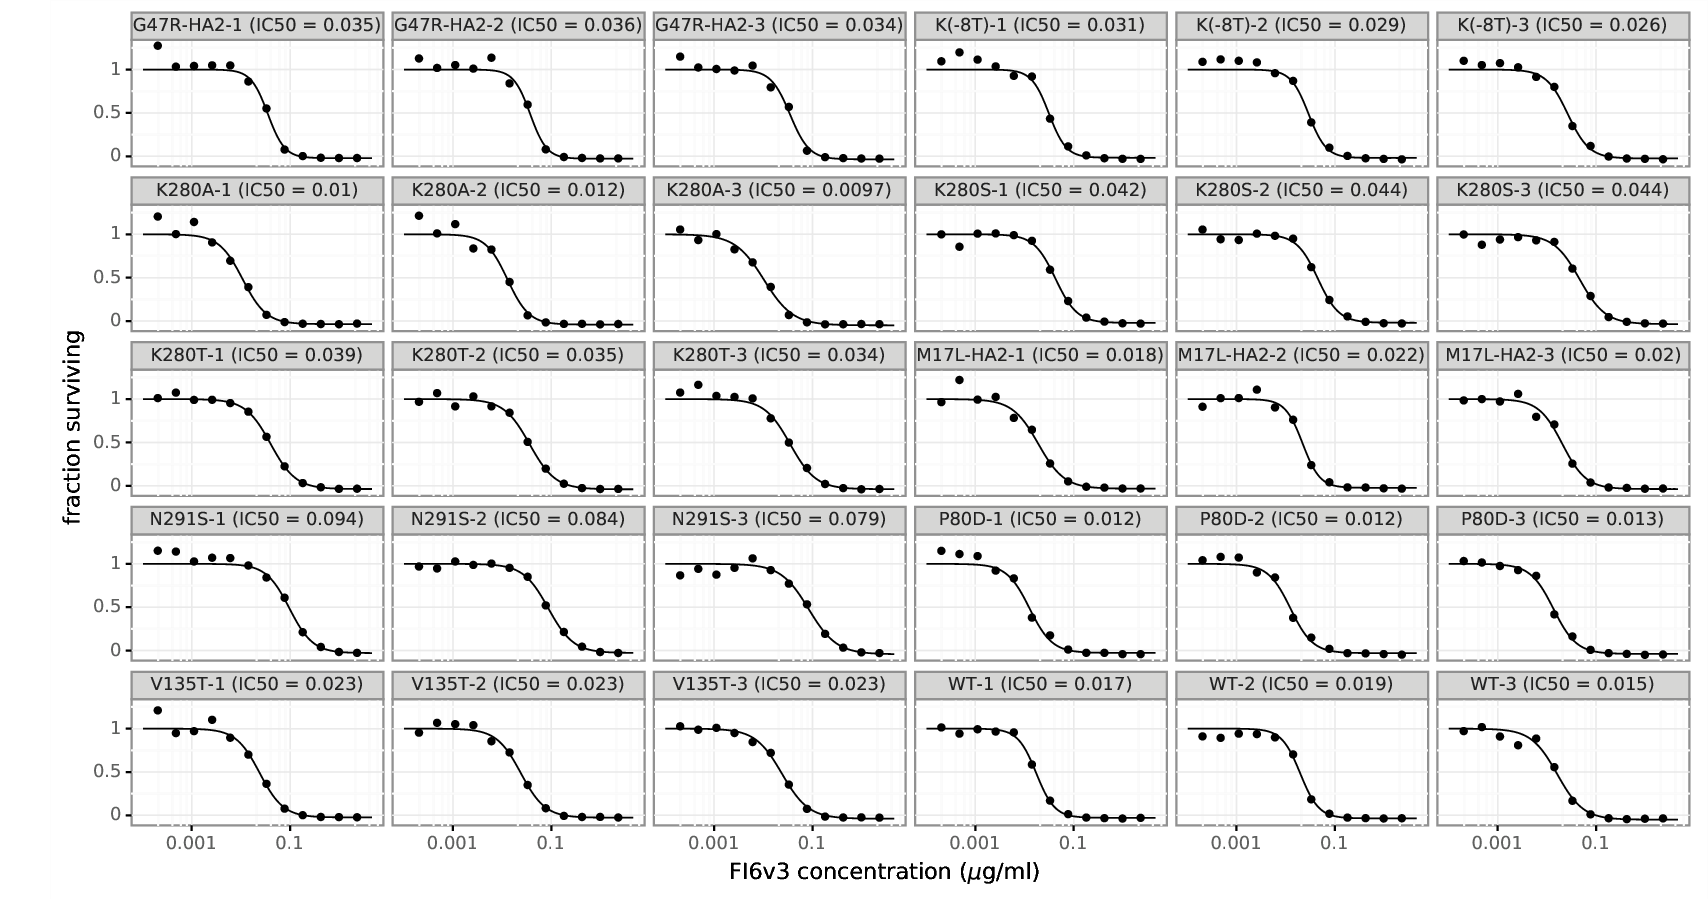

In [2]:
neutdata = pandas.read_csv('platereaderdata/FI6v3_neutcurves.csv')

neutplot = 'FI6v3_replicate_neutcurves.pdf'
neutcurves = dms_tools2.neutcurve.fit_fourParamLogistics(
        neutdata, neutplot, maxcol=6, xlabel='FI6v3 concentration ($\mu$g/ml)')

showPDF(neutplot)

## Test if IC50s significantly differ between wildtype and the variants
We have three IC50 values fitted for each variant, and three for wildtype.
We use an [unpaired t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_(unpaired)_samples) with unequal variances to test if the IC50s are different between wildtype and each variant.

Since we are testing many variants, then then apply a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to get a corrected P-value.

We then display the results, and also write the table in `LaTex` format:

In [3]:
# get variants so that wildtype is last 
variants = sorted(set(['-'.join(s.split('-')[ : -1])
        for s in neutcurves.keys() if 'WT' not in s]))
variants.append('WT')

# there are 3 replicates for each variant
replicates = [1, 2, 3]

# extract fitted IC50s
ic50_df = pandas.DataFrame.from_items([('variant', variants)] +
        [(r, [neutcurves['{0}-{1}'.format(v, r)].ic50() for v in variants]) for r in replicates]
        )
ic50_df['mean'] = ic50_df[replicates].mean(axis=1)

# now compute corrected P-values that IC50 is different than for wildtype
wt_ic50s = ic50_df.query('variant == "WT"')[replicates].values.flatten()
pvals = []
for v in variants[ : -1]:
    v_ic50s = ic50_df.query('variant == @v')[replicates].values.flatten()
    pvals.append(ttest_ind(wt_ic50s, v_ic50s, equal_var=False)[1])
qvals = multipletests(pvals, method='bonferroni')[1]
qvals = list(qvals) + [numpy.nan]
ic50_df['Pcorr'] = qvals

# display the results
ic50_df = (ic50_df
           .sort_values('Pcorr')
           .rename(columns=dict([(r, 'replicate-{0}'.format(r)) for r in replicates]))
           )
print("IC50 values and corrected P-value they differ from wildtype:")
display(HTML(ic50_df.to_html(index=False, float_format='%.2g')))

# also write to LaTex
latex_table = 'FI6v3_replicate_IC50s.tex'
print("Writing the table to {0}".format(latex_table))
with open(latex_table, 'w') as f:
    ic50_df.to_latex(f, index=False, float_format='%.2g', bold_rows=True)

IC50 values and corrected P-value they differ from wildtype:


variant,replicate-1,replicate-2,replicate-3,mean,Pcorr
K280S,0.042,0.044,0.044,0.043,0.00072
G47R-HA2,0.035,0.036,0.034,0.035,0.0037
K280T,0.039,0.035,0.034,0.036,0.0087
N291S,0.094,0.084,0.079,0.086,0.023
K(-8T),0.031,0.029,0.026,0.029,0.04
K280A,0.01,0.012,0.0097,0.011,0.12
V135T,0.023,0.023,0.023,0.023,0.27
P80D,0.012,0.012,0.013,0.013,0.42
M17L-HA2,0.018,0.022,0.02,0.02,1
WT,0.017,0.019,0.015,0.017,NaN


Writing the table to FI6v3_replicate_IC50s.tex
